## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [13]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [14]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist already exists!


In [15]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

In [16]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [17]:
len(fmnist_dataset_test)

10000

In [18]:
for img, label in train_loader:
    print(img.shape)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


In [19]:
import matplotlib.pyplot as plt

In [20]:
img = img.reshape(128, 28, 28)
img.sum(axis=0).shape

torch.Size([28, 28])

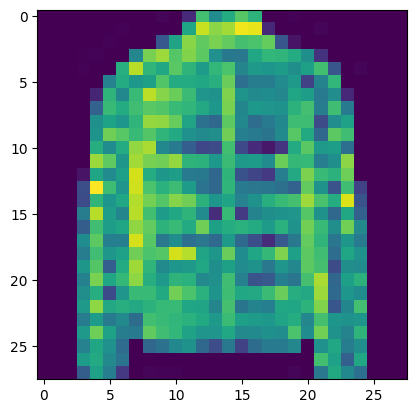

In [21]:
plt.imshow(X=img[3].reshape(28, 28),)

### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [44]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            #nn.Linear(input_shape, num_classes)
            nn.Linear(input_shape, 16*16),
            nn.BatchNorm1d(num_features=16*16),
            nn.LeakyReLU(),
            nn.Linear(16*16, num_classes),
            nn.BatchNorm1d(num_features=num_classes),
            nn.LeakyReLU(),
        )
        
    def forward(self, inp):       
        return self.model(inp)
        out =  self.model(inp)

In [45]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 256]         200,960
       BatchNorm1d-3                  [-1, 256]             512
         LeakyReLU-4                  [-1, 256]               0
            Linear-5                   [-1, 10]           2,570
       BatchNorm1d-6                   [-1, 10]              20
         LeakyReLU-7                   [-1, 10]               0
Total params: 204,062
Trainable params: 204,062
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.78
Estimated Total Size (MB): 0.79
----------------------------------------------------------------


Your experiments come here:

**I'll code some functions for convenience**

In [46]:
from torch.optim import Adam

In [47]:
model = TinyNeuralNetwork().to(device)
opt = Adam(params=model.parameters(), lr=1e-4,) #eps=1e-8, betas=(0.9, 0.999), weight_decay=0.99) # YOUR CODE HERE
loss_func = nn.CrossEntropyLoss()

# Your experiments, training and validation loops here

Test set will be use as validation just because it's an educational task, but ofc there has to be train/val split and test must be done after **pipeline of validation**

In [57]:
import time

In [61]:
def train_model(model, train_loader, val_loader, loss_fn, opt, n_epochs: int):
    train_loss = []
    val_loss = []
    val_accuracy = []
    
    for epoch in range(n_epochs):
        ep_train_loss = []
        ep_val_loss = []
        ep_val_accuracy = []
        start_time = time.time()

        model.train(True) # enable dropout / batch_norm training behavior
        for X_batch, y_batch in train_loader:
            # move data to target device
            ### YOUR CODE HERE
            X_batch = X_batch.to(device, torch.float32)
            y_batch = y_batch.to(device, torch.long)
            X_batch.requires_grad = True
            #y_batch.requires_grad = True

            # train on batch: compute loss, calc grads, perform optimizer step and zero the grads
            ### YOUR CODE HERE
            model.zero_grad()

            predictions = model(X_batch)
            loss = loss_fn.forward(input=predictions, target=y_batch)
            loss.backward()
            opt.step()

            ep_train_loss.append(loss.item())

        model.train(False) # disable dropout / use averages for batch_norm
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                # move data to target device
                ### YOUR CODE HERE
                X_batch = X_batch.to(device, torch.float32)
                y_batch = y_batch.to(device, torch.long)
                # compute predictions
                ### YOUR CODE HERE
                predictions_val = model(X_batch)
                ep_val_loss.append(loss_fn(input=predictions_val, target=y_batch).item())
                y_pred = predictions_val.max(axis=-1).indices ### YOUR CODE HERE
                accuracy = (y_pred == y_batch).detach().cpu().numpy().mean()
                ep_val_accuracy.append(accuracy)

        # print the results for this epoch:
        print(f'Epoch {epoch + 1} of {n_epochs} took {time.time() - start_time:.3f}s')

        train_loss.append(np.mean(ep_train_loss))
        val_loss.append(np.mean(ep_val_loss))
        val_accuracy.append(np.mean(ep_val_accuracy))
        
        print(f"\t  training loss: {train_loss[-1]:.6f}")
        print(f"\tvalidation loss: {val_loss[-1]:.6f}")
        print(f"\tvalidation accuracy: {val_accuracy[-1]:.3f}")

    return train_loss, val_loss, val_accuracy

In [50]:
n_epochs = 30

train_loss, val_loss, val_accuracy = train_model(model, train_loader, test_loader, loss_func, opt, n_epochs)

Epoch 1 of 30 took 9.744s
	  training loss: 0.937365
	validation loss: 0.787800
	validation accuracy: 0.845
Epoch 2 of 30 took 9.153s
	  training loss: 0.726933
	validation loss: 0.704029
	validation accuracy: 0.851
Epoch 3 of 30 took 8.538s
	  training loss: 0.658782
	validation loss: 0.655239
	validation accuracy: 0.871
Epoch 4 of 30 took 9.210s
	  training loss: 0.608779
	validation loss: 0.594170
	validation accuracy: 0.872
Epoch 5 of 30 took 9.112s
	  training loss: 0.565021
	validation loss: 0.567628
	validation accuracy: 0.875
Epoch 6 of 30 took 8.281s
	  training loss: 0.526271
	validation loss: 0.544622
	validation accuracy: 0.877
Epoch 7 of 30 took 8.304s
	  training loss: 0.496678
	validation loss: 0.522930
	validation accuracy: 0.878
Epoch 8 of 30 took 8.154s
	  training loss: 0.465512
	validation loss: 0.527269
	validation accuracy: 0.875
Epoch 9 of 30 took 8.303s
	  training loss: 0.439775
	validation loss: 0.500020
	validation accuracy: 0.879
Epoch 10 of 30 took 8.151s
	

In [53]:
def plot_train_process(train_loss, val_loss, val_accuracy):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].set_title('Loss')
    axes[0].plot(train_loss, label='train')
    axes[0].plot(val_loss, label='validation')
    axes[0].legend()

    axes[1].set_title('Validation accuracy')
    axes[1].plot(val_accuracy)

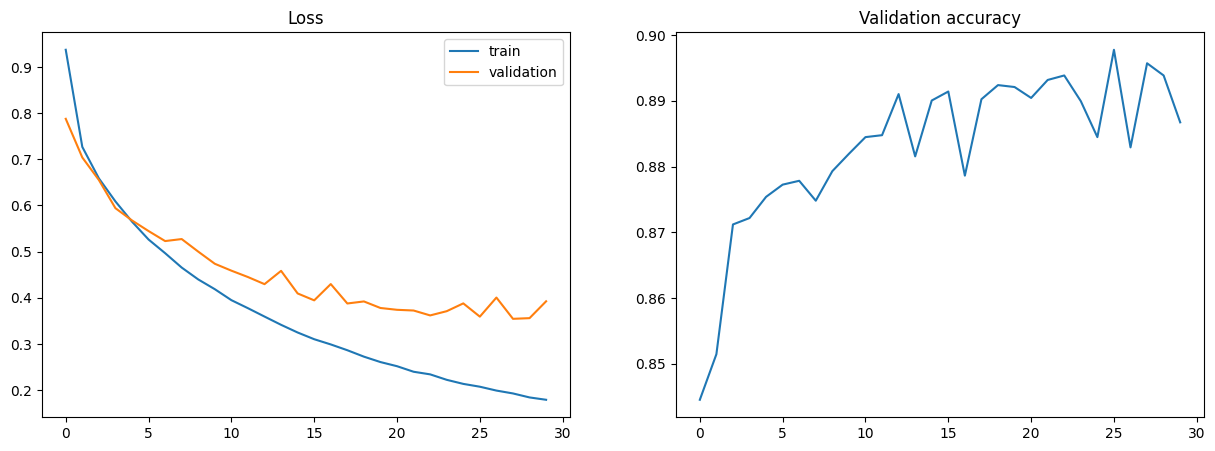

In [54]:
plot_train_process(train_loss, val_loss, val_accuracy)

Simple model without overfitting (check graph) and decent accuracy

### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [67]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 64*64),
            nn.LeakyReLU(),
            nn.Linear(64*64, 64*64),
            nn.LeakyReLU(),
            nn.Linear(64*64, 32*32),
            nn.LeakyReLU(),
            nn.Linear(32*32, 16*16),
            nn.LeakyReLU(),
            nn.Linear(16*16, num_classes),
            nn.LeakyReLU(),
        )
        
    def forward(self, inp):  
        return self.model(inp)     
        out = self.model(inp)

**I'll just add some many "tall" layers for no reason -> overfitting**

In [68]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 4096]       3,215,360
         LeakyReLU-3                 [-1, 4096]               0
            Linear-4                 [-1, 4096]      16,781,312
         LeakyReLU-5                 [-1, 4096]               0
            Linear-6                 [-1, 1024]       4,195,328
         LeakyReLU-7                 [-1, 1024]               0
            Linear-8                  [-1, 256]         262,400
         LeakyReLU-9                  [-1, 256]               0
           Linear-10                   [-1, 10]           2,570
        LeakyReLU-11                   [-1, 10]               0
Total params: 24,456,970
Trainable params: 24,456,970
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Fo

In [69]:
model = OverfittingNeuralNetwork().to(device)
opt = Adam(params=model.parameters(), lr=1e-4,) #eps=1e-8, betas=(0.9, 0.999), weight_decay=0.99) # YOUR CODE HERE
loss_func = nn.CrossEntropyLoss()

# Your experiments, come here

In [70]:
n_epochs = 30

train_loss, val_loss, val_accuracy = train_model(model, train_loader, test_loader, loss_func, opt, n_epochs)

Epoch 1 of 30 took 15.251s
	  training loss: 0.625727
	validation loss: 0.430495
	validation accuracy: 0.847
Epoch 2 of 30 took 14.841s
	  training loss: 0.374415
	validation loss: 0.401499
	validation accuracy: 0.860
Epoch 3 of 30 took 14.715s
	  training loss: 0.324540
	validation loss: 0.359214
	validation accuracy: 0.868
Epoch 4 of 30 took 14.772s
	  training loss: 0.293693
	validation loss: 0.370495
	validation accuracy: 0.865
Epoch 5 of 30 took 14.226s
	  training loss: 0.271214
	validation loss: 0.322662
	validation accuracy: 0.882
Epoch 6 of 30 took 14.238s
	  training loss: 0.248991
	validation loss: 0.314826
	validation accuracy: 0.887
Epoch 7 of 30 took 14.906s
	  training loss: 0.233439
	validation loss: 0.304403
	validation accuracy: 0.892
Epoch 8 of 30 took 15.614s
	  training loss: 0.215645
	validation loss: 0.311943
	validation accuracy: 0.890
Epoch 9 of 30 took 14.950s
	  training loss: 0.199688
	validation loss: 0.305715
	validation accuracy: 0.890
Epoch 10 of 30 took

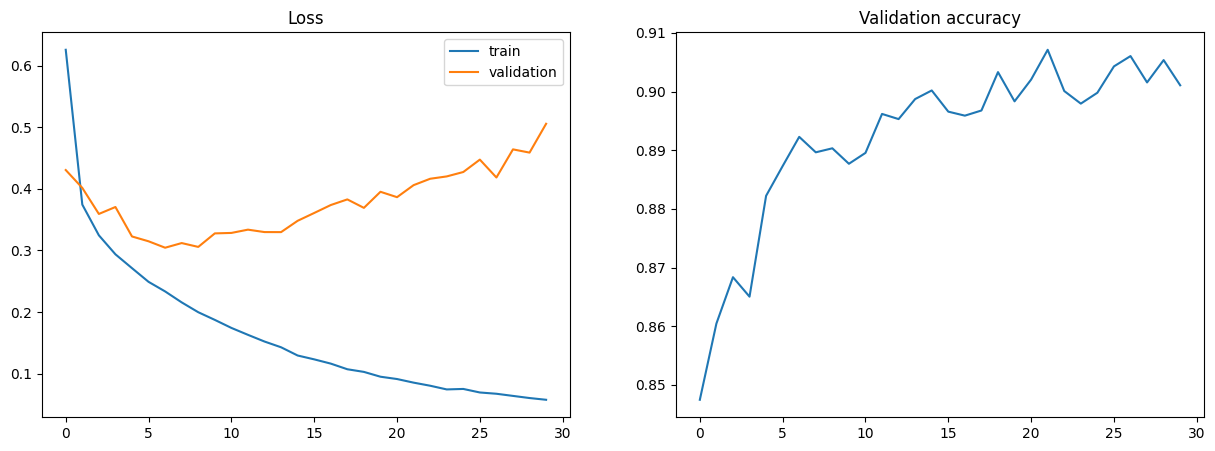

In [72]:
plot_train_process(train_loss, val_loss, val_accuracy)

Yeah, I overfitted it **CHAD**. Model is not sure in its predictions on validation set, so validation loss is high. Accuracy is ok because it still guesses right despite of the overfitting. Thus, the overfitting is not catastrophic, but still shitty

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [73]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 64*64),
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            nn.Linear(64*64, 64*64),
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            nn.Linear(64*64, 32*32),
            nn.Dropout(0.5),
            nn.LeakyReLU(),
            nn.Linear(32*32, 16*16),
            nn.Dropout(0.5),
            nn.LeakyReLU(),
            nn.Linear(16*16, num_classes),
            nn.LeakyReLU(),
        )
        
    def forward(self, inp):
        return self.model(inp)       
        out = self.model(inp)

**For that I just added droupouts, since there are a lot of tall layers**

In [ ]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

In [74]:
model = FixedNeuralNetwork().to(device)
opt = Adam(params=model.parameters(), lr=1e-4,) #eps=1e-8, betas=(0.9, 0.999), weight_decay=0.99) # YOUR CODE HERE
loss_func = nn.CrossEntropyLoss()
# Your experiments, come here

In [75]:
n_epochs = 30

train_loss, val_loss, val_accuracy = train_model(model, train_loader, test_loader, loss_func, opt, n_epochs)

Epoch 1 of 30 took 15.903s
	  training loss: 0.827816
	validation loss: 0.484179
	validation accuracy: 0.828
Epoch 2 of 30 took 13.873s
	  training loss: 0.461233
	validation loss: 0.422722
	validation accuracy: 0.850
Epoch 3 of 30 took 16.392s
	  training loss: 0.406857
	validation loss: 0.384000
	validation accuracy: 0.861
Epoch 4 of 30 took 16.519s
	  training loss: 0.375490
	validation loss: 0.364310
	validation accuracy: 0.870
Epoch 5 of 30 took 15.288s
	  training loss: 0.353587
	validation loss: 0.356470
	validation accuracy: 0.873
Epoch 6 of 30 took 14.597s
	  training loss: 0.338242
	validation loss: 0.346516
	validation accuracy: 0.878
Epoch 7 of 30 took 14.617s
	  training loss: 0.321876
	validation loss: 0.341237
	validation accuracy: 0.878
Epoch 8 of 30 took 14.537s
	  training loss: 0.312680
	validation loss: 0.330690
	validation accuracy: 0.883
Epoch 9 of 30 took 14.436s
	  training loss: 0.303417
	validation loss: 0.324091
	validation accuracy: 0.881
Epoch 10 of 30 took

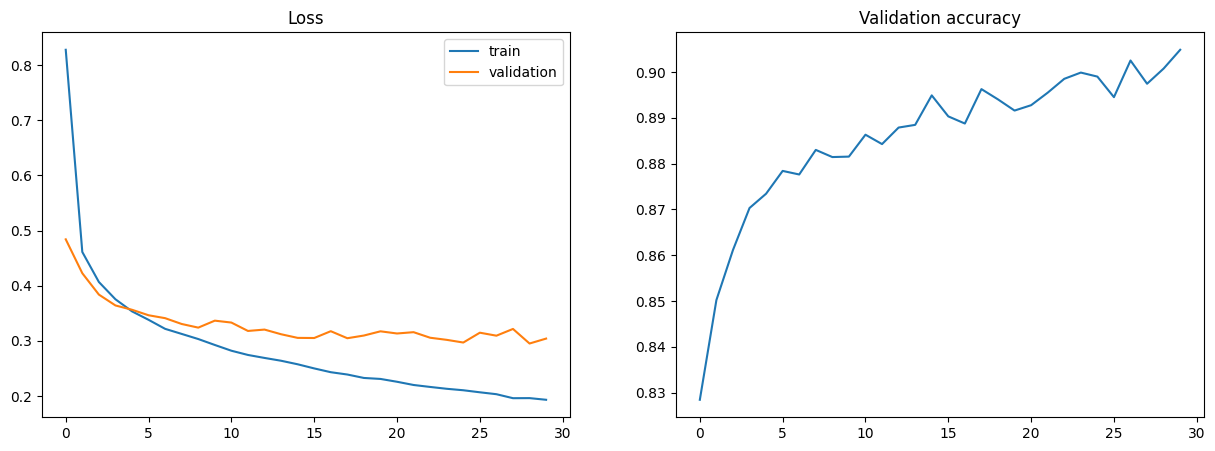

In [76]:
plot_train_process(train_loss, val_loss, val_accuracy)

**Now way better**

### Conclusions:
_Write down small report with your conclusions and your ideas._

**Me:** In practice, it seems like if u don't know the approximate number of parameters u need to train a decent model without running into overfitting, you should probably either look at some papers with similar datasets/tasks/etc. or try out different architectures and then use some regularizations